In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Layer, Rescaling, GlobalAveragePooling2D, Dense,
    BatchNormalization, Dropout, RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
import gradio as gr
import cv2
import os


In [37]:
dataset_dir = "dataset"
image_size = (260, 260)  # ✅ Update this globally wherever used
batch_size = 32
seed = 42

In [38]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [39]:
# Load validation dataset (no cache/prefetch yet)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Extract class names before wrapping with cache/prefetch
val_class = val_ds_raw.class_names

# Add cache and prefetch separately
val_ds = val_ds_raw.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [40]:
# Get number of batches in the full validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split into test and actual validation set
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

# Optional: prefetch again to be safe
test_ds_eval = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dat = val_dat.prefetch(buffer_size=tf.data.AUTOTUNE)


In [41]:
# Reload training dataset without cache to get class names
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

train_class = train_ds_raw.class_names  # ✅ Extract before caching

# Print class info
print("Training Classes:", train_class)
print("Validation Classes:", val_class)
print("Number of Classes:", len(train_class))


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Training Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Validation Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of Classes: 6


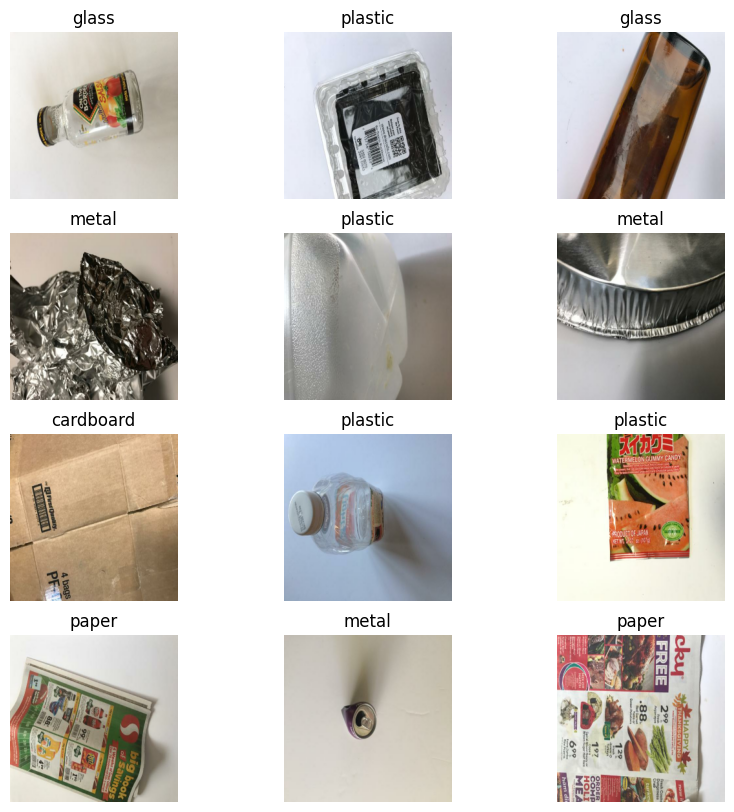

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_class[labels[i]])  # ✅ Use saved class list
        plt.axis("off")


In [44]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [46]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [47]:
# Use the extracted class names from raw dataset
class_names = train_class  # class names were extracted before caching in Cell 6

# Get class distributions using the count_distribution() function from Cell 8
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)

# Compute overall class distribution (average of train and validation)
overall_dist = {
    k: round((train_dist[k] + val_dist[k]) / 2, 2)
    for k in class_names
}

# Display the results
print("📦 Train Distribution:", train_dist)
print("🧪 Validation Distribution:", val_dist)
print("🧫 Test Distribution:", test_dist)
print("📊 Overall Distribution:", overall_dist)


📦 Train Distribution: {'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
🧪 Validation Distribution: {'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
🧫 Test Distribution: {'cardboard': 14.84, 'glass': 16.8, 'metal': 18.75, 'paper': 25.39, 'plastic': 16.41, 'trash': 7.81}
📊 Overall Distribution: {'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


In [48]:
# Reload training dataset without cache to get class names
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

train_class = train_ds_raw.class_names  # ✅ Extract before caching

# Print class info
print("Training Classes:", train_class)
print("Validation Classes:", val_class)
print("Number of Classes:", len(train_class))


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Training Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Validation Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of Classes: 6


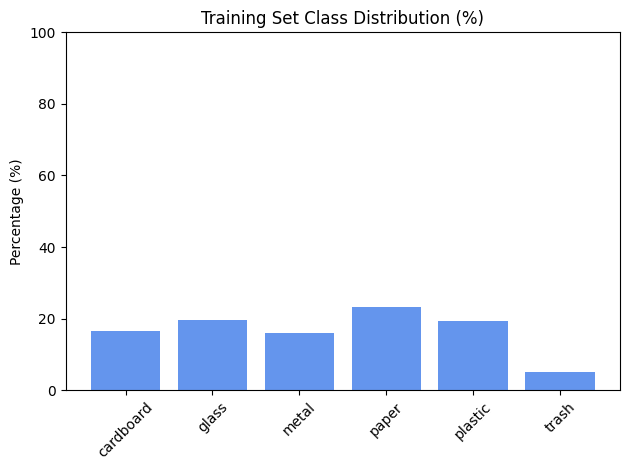

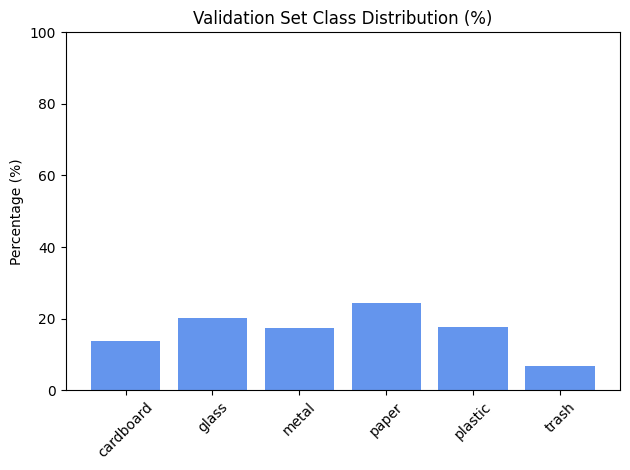

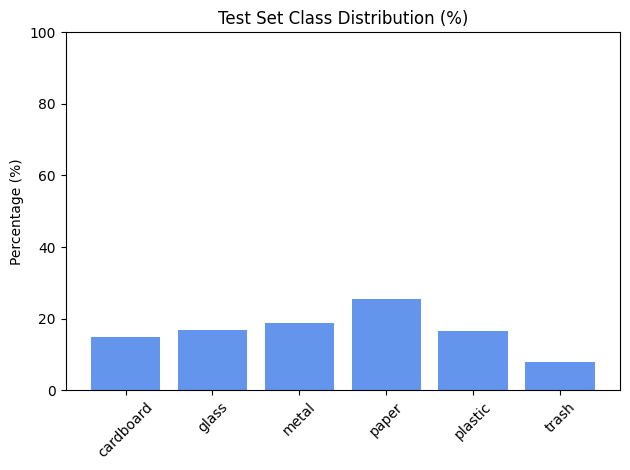

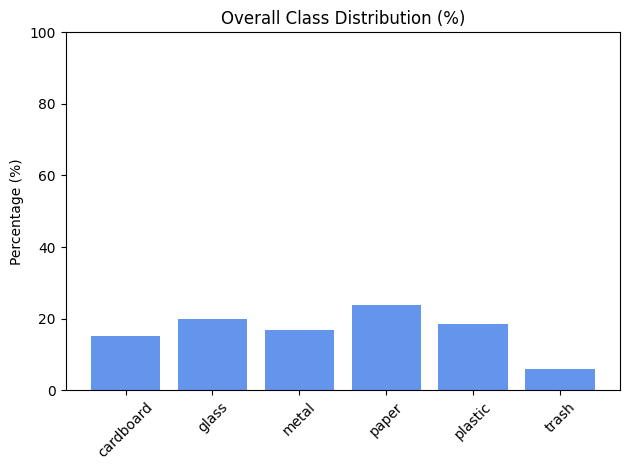

In [49]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [50]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [51]:
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


In [52]:
# Define data augmentation pipeline
from tensorflow.keras import layers  # Add this import
from tensorflow.keras.models import Sequential  # Already in first cell, included for clarity
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [53]:
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(260, 260, 3),
    include_preprocessing=True,
    weights='imagenet'
)

#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

In [54]:
model = Sequential([
    layers.Input(shape=(260, 260, 3)),  # ✅ UPDATED HERE
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])


In [55]:
# ✅ Recommended Cell 18 without label_smoothing (safe for all TF versions)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)


In [56]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [24]:
# Number of epochs (early stopping will prevent overfitting)
epochs = 20

# ✅ Save best model (based on validation accuracy)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",           # Saved in TensorFlow’s new format
    monitor="val_accuracy",       # Maximize validation accuracy
    save_best_only=True,          # Only keep best weights
    save_weights_only=False,
    verbose=1
)

# ✅ Train the model
history = model.fit(
    train_ds,                    # Your training data (cached + prefetched)
    validation_data=val_dat,     # Your split validation dataset (not test_ds!)
    epochs=epochs,
    class_weight=class_weights,  # Correct for class imbalance
    callbacks=[early, checkpoint],
    verbose=1
)


Epoch 1/20
64/64 [==============================] - ETA: 0s - loss: 0.9486 - accuracy: 0.7394
Epoch 1: val_accuracy improved from -inf to 0.81526, saving model to best_model.keras
64/64 [==============================] - 218s 3s/step - loss: 0.9486 - accuracy: 0.7394 - val_loss: 0.6324 - val_accuracy: 0.8153
Epoch 2/20
64/64 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.8591
Epoch 2: val_accuracy improved from 0.81526 to 0.87149, saving model to best_model.keras
64/64 [==============================] - 189s 3s/step - loss: 0.5108 - accuracy: 0.8591 - val_loss: 0.3987 - val_accuracy: 0.8715
Epoch 3/20
64/64 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.9159
Epoch 3: val_accuracy improved from 0.87149 to 0.87550, saving model to best_model.keras
64/64 [==============================] - 194s 3s/step - loss: 0.2954 - accuracy: 0.9159 - val_loss: 0.3258 - val_accuracy: 0.8755
Epoch 4/20
64/64 [==============================] - ETA: 0s - lo

In [57]:
# 📝 Summary (optional but useful)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 260, 260, 3)       0         
                                                                 
 efficientnetv2-b2 (Function  (None, 9, 9, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1408)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 8454      
                                                                 
Total params: 8,777,828
Trainable params: 7,974,642
No

In [58]:
base_model.summary()

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 260, 260, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 260, 260, 3)  0          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                  

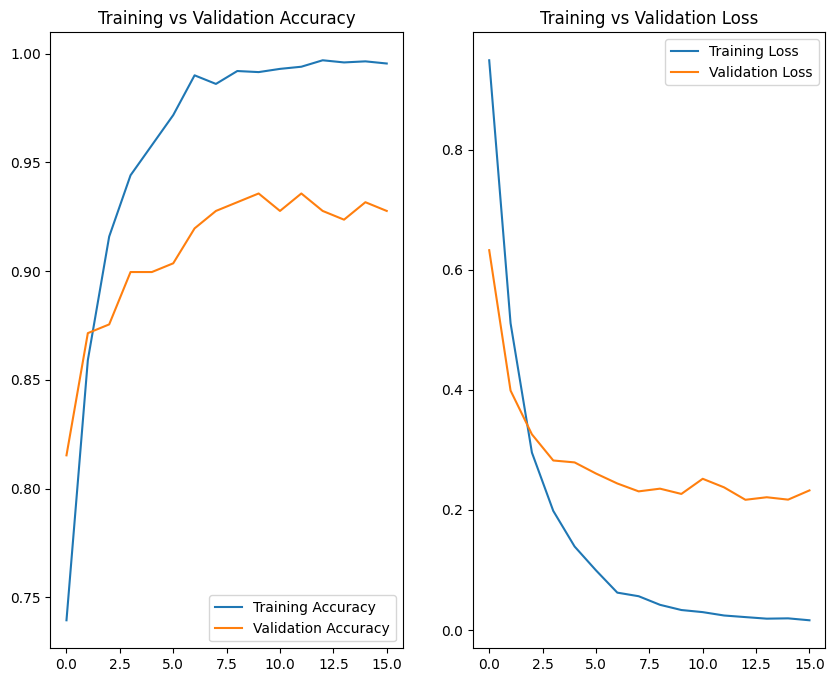

In [59]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()    

In [62]:
from tensorflow.keras.models import load_model

model = load_model("best_model.keras")
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')


8/8 [==============================] - 11s 1s/step - loss: 0.1614 - accuracy: 0.9492
Test accuracy is 0.9492, Test loss is 0.1614


In [63]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

8/8 [==============================] - 11s 1s/step
[[37  0  0  1  0  0]
 [ 0 38  4  0  1  0]
 [ 0  0 46  0  1  1]
 [ 1  0  0 64  0  0]
 [ 0  0  0  0 40  2]
 [ 0  0  1  1  0 18]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        38
           1       1.00      0.88      0.94        43
           2       0.90      0.96      0.93        48
           3       0.97      0.98      0.98        65
           4       0.95      0.95      0.95        42
           5       0.86      0.90      0.88        20

    accuracy                           0.95       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.95      0.95      0.95       256



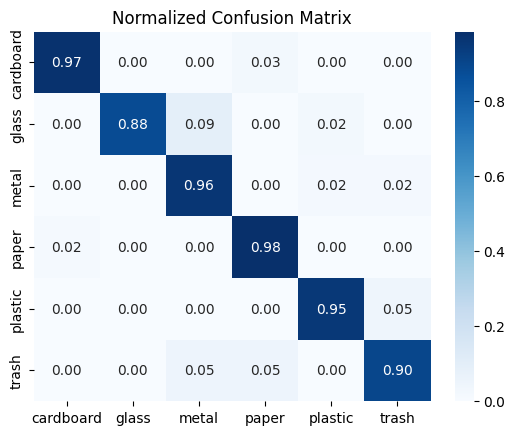

In [64]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.2f',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.show()


1/1 [==============================] - 2s 2s/step


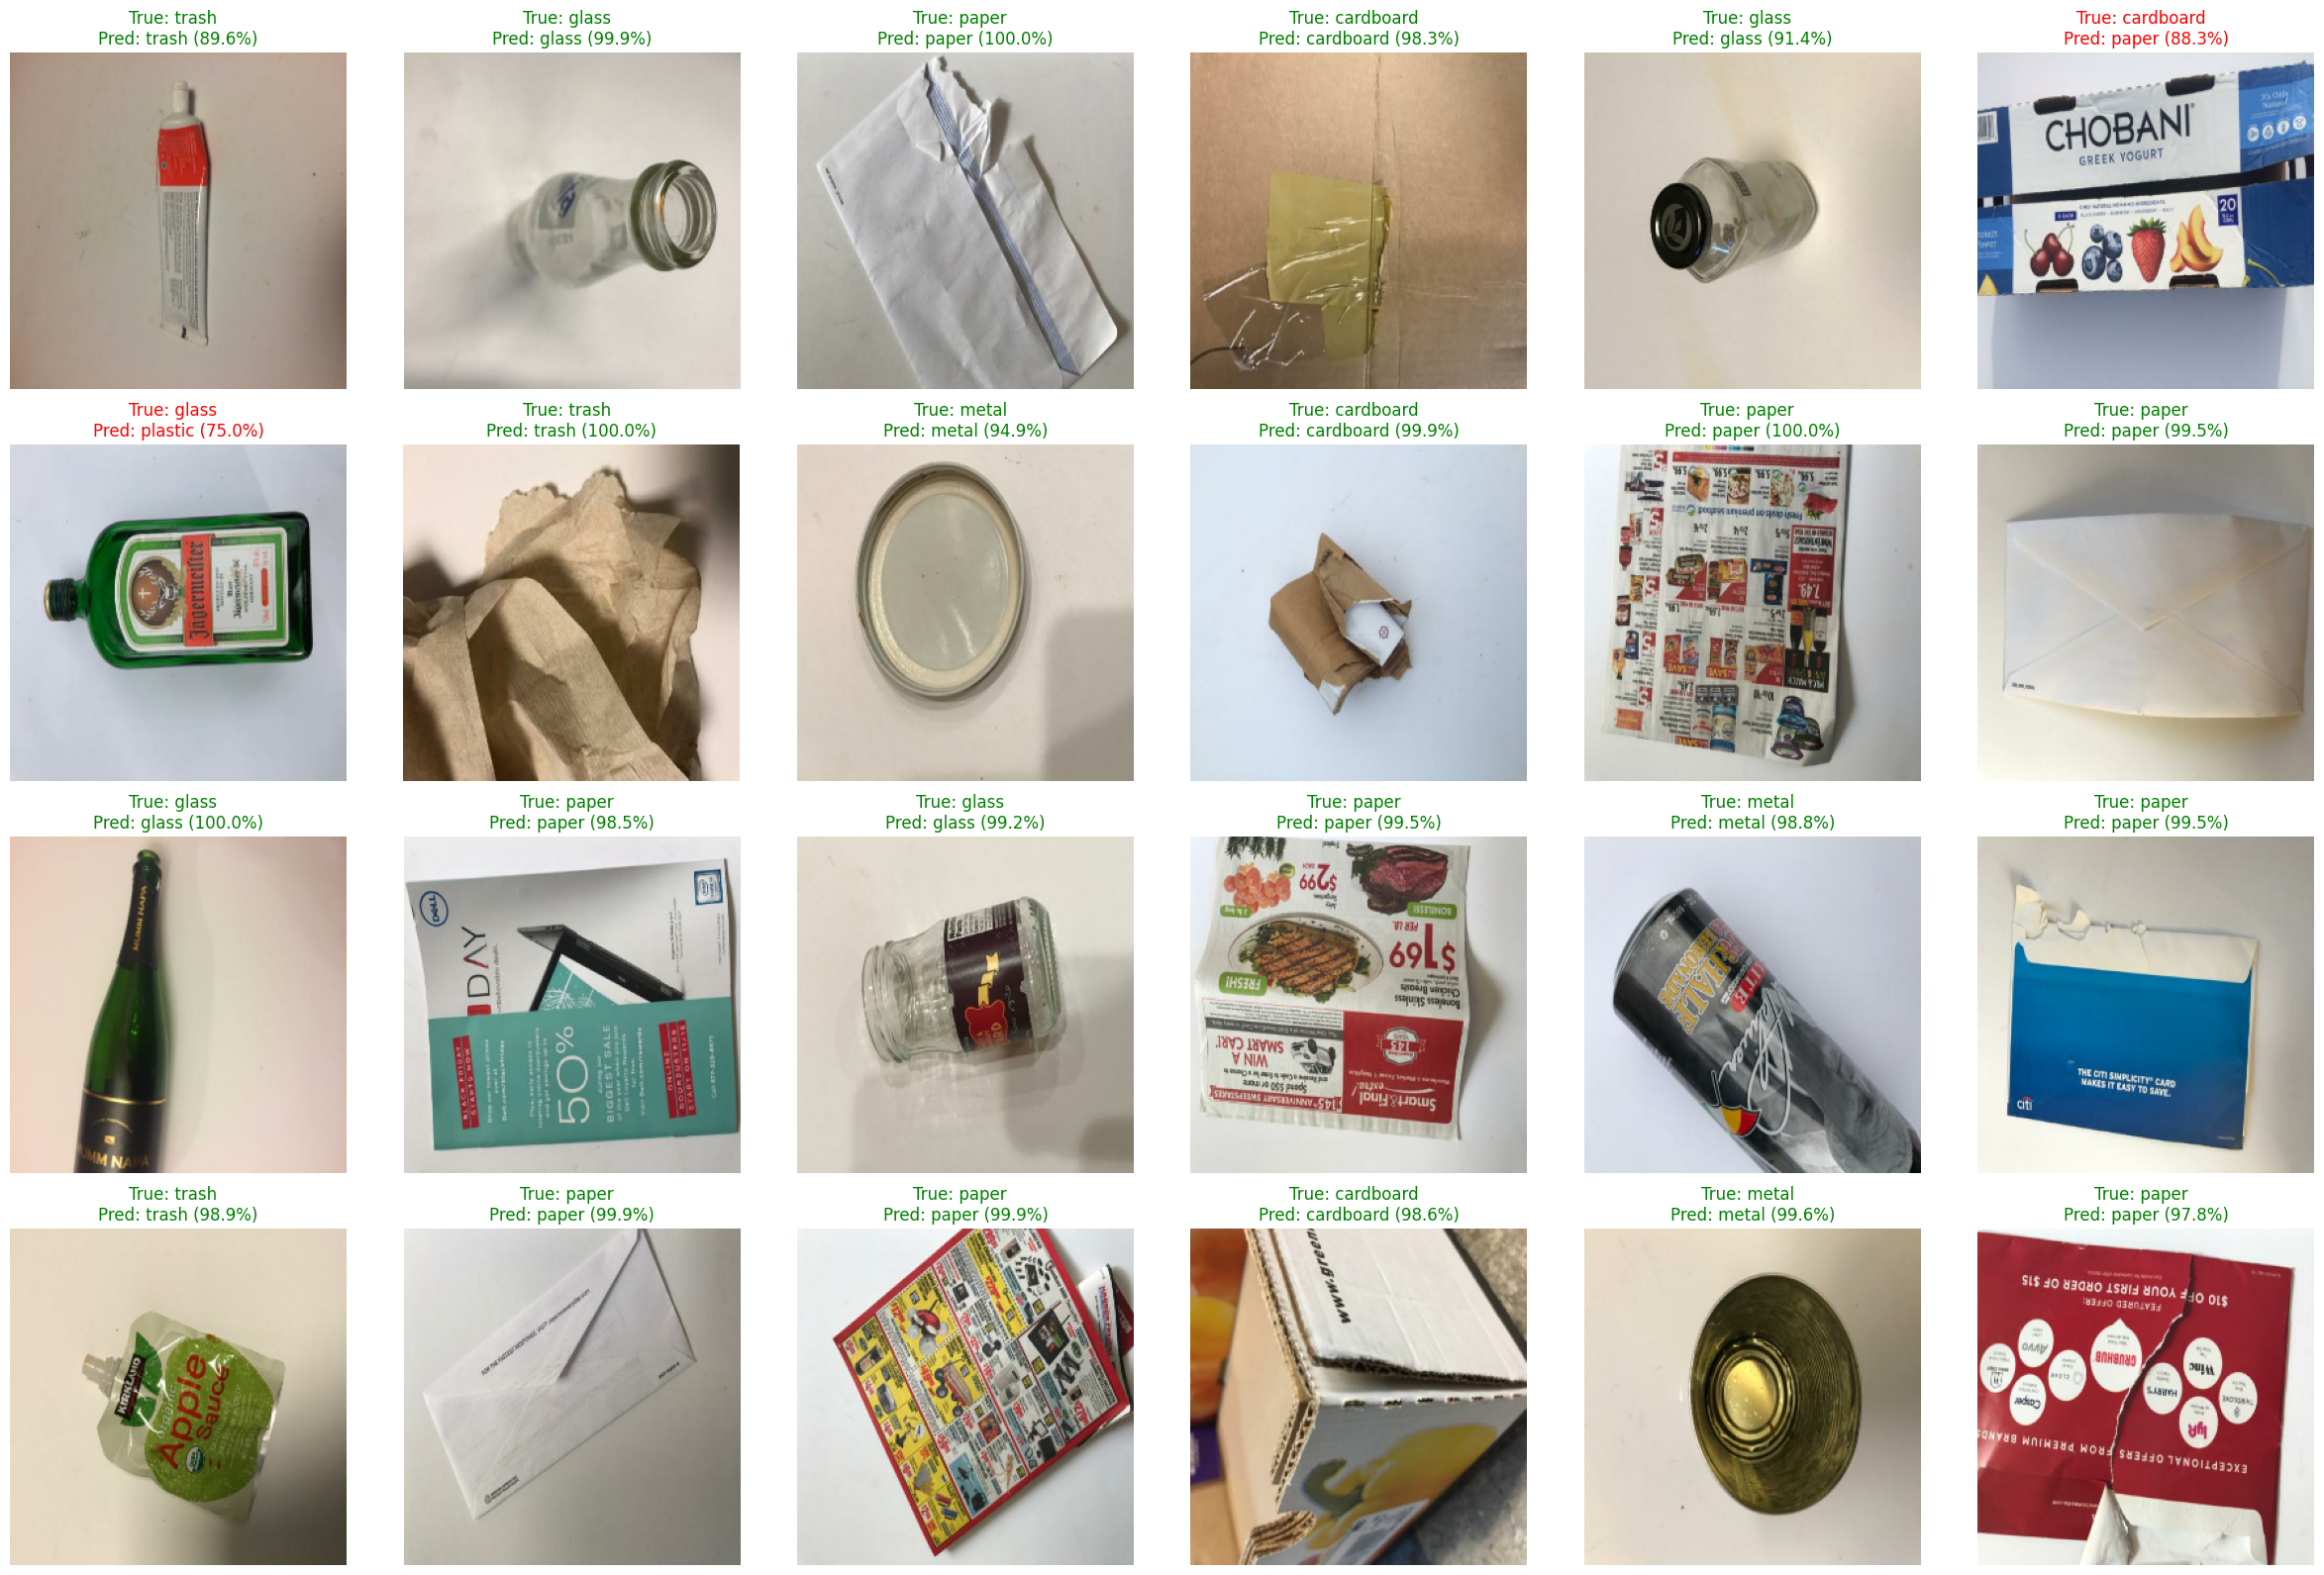

In [74]:
# ✅ Use the class names already extracted in Cell 6
class_names = train_class  # train_class was defined earlier

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):
    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # ✅ Convert to NumPy arrays for clean indexing & comparison
    pred_labels = pred_labels.numpy()
    labels = labels.numpy()

    # Display the first 24 images with prediction results
    plt.figure(figsize=(24, 16))   # Wider figure for 6 columns
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)  # 4 rows × 6 columns
        plt.imshow(images[i].numpy().astype("uint8"))

        # Compute prediction confidence (max softmax probability)
        confidence = tf.reduce_max(predictions[i]).numpy() * 100

        # Color the title green if correct, red if incorrect
        color = "green" if int(pred_labels[i]) == int(labels[i]) else "red"

        # Display title with True, Predicted class & confidence
        plt.title(
            f"True: {class_names[int(labels[i])]}  \n"
            f"Pred: {class_names[int(pred_labels[i])]} ({confidence:.1f}%)",
            color=color
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [70]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [71]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

# ✅ Load the best saved model
model = load_model('best_model.keras')

# ✅ Use your saved class names (from Cell 6 or earlier)
class_names = train_class  # Already extracted during training

# ✅ Define image classification function
def classify_image(img):
    try:
        # 🖼️ Resize image to match model input size
        img = img.resize((260, 260))  # Match your EfficientNetV2B2 input size

        # 🔄 Convert image to NumPy array and preprocess
        img_array = np.array(img, dtype=np.float32)
        img_array = preprocess_input(img_array)  # EfficientNetV2 expects preprocessed input
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # 🔍 Make prediction
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_names[predicted_class_index]
        confidence = prediction[0][predicted_class_index]

        return f"✅ Predicted: {predicted_class_name} (Confidence: {confidence:.2%})"
    
    except Exception as e:
        return f"❌ Error: {str(e)}"


In [72]:
iface = gr.Interface(  
    fn=classify_image,  # Function to classify image using the trained model  
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image  
    outputs="text"  # Outputs prediction as text  
)  

# Launch the interface  
iface.launch()  # Start the Gradio interface for user interaction

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 186ms/step
